In [141]:
from __future__ import division
import os
import sys
import pdb
import time
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import transforms, utils

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import dask.dataframe as dd
from sklearn import preprocessing
from collections import OrderedDict
from matplotlib import pyplot as plt

### Preprocessing

In [ ]:
df = dd.read_csv('/mnt/disks/open-images/metadata/bboxes/train-annotations-bbox.csv')
df.to_parquet('data/parquet', engine='fastparquet')

In [4]:
datasets = {}
datasets["training"] = {"path":"/mnt/disks/open-images/metadata/bboxes/train-annotations-bbox.csv"}

In [5]:
# Check number of lines
train_num_lines = !wc -l /mnt/disks/open-images/metadata/bboxes/train-annotations-bbox.csv | awk '{ print $1 }'
train_num_lines = int(train_num_lines[0])
print(train_num_lines)

14610230


In [56]:
def write_output(output):
    sys.stdout.write('\r'+output)
    sys.stdout.flush()

Groups work like dictionaries, and datasets work like NumPy arrays

In [2]:
!ls data/parquet  

_common_metadata  part.13.parquet  part.1.parquet  part.7.parquet
_metadata	  part.14.parquet  part.2.parquet  part.8.parquet
part.0.parquet	  part.15.parquet  part.3.parquet  part.9.parquet
part.10.parquet   part.16.parquet  part.4.parquet
part.11.parquet   part.17.parquet  part.5.parquet
part.12.parquet   part.18.parquet  part.6.parquet


In [6]:
df = dd.read_parquet('data/parquet', engine='fastparquet')

In [48]:
df.head(20)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0
5,000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0
6,000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0
7,000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0
8,000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0
9,000002b66c9c498e,xclick,/m/04bcr3,1,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0


In [49]:
counts = pd.DataFrame(df.groupby(df["ImageID"]).size().compute())

In [54]:
counts.reset_index(level=0, inplace=True)

In [55]:
counts.columns = ["ImageID", "Count"]

In [57]:
counts.head()

,ImageID,Count
0,000002b66c9c498e,13
1,000002b97e5471a0,11
2,000002c707c9895e,1
3,0000048549557964,12
4,000004f4400f6ec5,25


In [58]:
counts.to_csv('data/index.csv')

In [4]:
# Check number of lines
index_num_lines = !wc -l data/index.csv | awk '{ print $1 }'
index_num_lines = int(index_num_lines[0])
print(index_num_lines)

1743043


### File conversion

In [50]:
def create_hdf5(csv_path, chunksize, output, num_lines, num_features=4):

    # this is your HDF5 database:
    with h5py.File(output, 'w') as h5f:

        string = h5py.special_dtype(vlen=str)
        # use num_features-1 if the csv file has a column header
        img_id_dataset = h5f.create_dataset('ids',
                                   shape=(num_lines,),
                                   compression=None,
                                   dtype=string)
        bbox_dataset = h5f.create_dataset('annotations',
                                   shape=(num_lines, num_features),
                                   compression=None,
                                   dtype='float64')

        # change range argument from 0 -> 1 if your csv file contains a column header
        for i in range(1, num_lines, chunksize):  

            df = pd.read_csv(csv_path,
                         header=None,
                         nrows=chunksize, # number of rows to read at each iteration
                         skiprows=i)   # skip rows that were already read
            
            # use i-1 and i-1+10 if csv file has a column header
            img_id_dataset[i:1+chunksize] = df.iloc[:, 0]
            bbox_dataset[i:1+chunksize] = df.iloc[:, 4:8]
            write_output(f"Chunk: {i}/{num_lines}")

In [54]:
def create_indexer_hdf5(csv_path, chunksize, output, num_lines, num_features=4):

    # this is your HDF5 database:
    with h5py.File(output, 'w') as h5f:

        string = h5py.special_dtype(vlen=str)
        # use num_features-1 if the csv file has a column header
        img_id_dataset = h5f.create_dataset('ids',
                                   shape=(num_lines,),
                                   compression=None,
                                   dtype=string)
        counts_dataset = h5f.create_dataset('counts',
                                   shape=(num_lines, num_features),
                                   compression=None,
                                   dtype="int32")

        # change range argument from 0 -> 1 if your csv file contains a column header
        for i in range(1, num_lines, chunksize):  

            df = pd.read_csv(csv_path,
                         header=None,
                         nrows=chunksize, # number of rows to read at each iteration
                         skiprows=i)      # skip rows that were already read
            # import pdb; pdb.set_trace()
            # use i-1 and i-1+10 if csv file has a column header
            img_id_dataset[i:1+chunksize] = df.iloc[:, 1]
            counts_dataset[i:1+chunksize] = df.iloc[:, 2:3]
            
            write_output(f"Chunk: {i}/{num_lines}")

In [46]:
# Already run
# create_hdf5("/mnt/disks/open-images/metadata/bboxes/train-annotations-bbox.csv", 10**6, "training.h5", train_num_lines)

In [57]:
create_indexer_hdf5("data/index.csv", 10**6, "index.h5", index_num_lines, num_features=2)

Chunk: 1000001/1743043

### Initialize Dataset class

In [166]:
class OpenImagesDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_dir, data_path, index_path, transform=None):
        
        self.data_dir = data_dir
        self.data = h5py.File("training.h5", "r")
        self.indexer = h5py.File("index.h5", "r")
        self.transform = transform
        
        self.current_index = 0
        
    def pad_to_square(self, img, pad_value=0):
        x, y, _ = img.shape
        dim_diff = np.abs(y - x)
        # (upper / left) padding and (lower / right) padding
        pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
        # Determine padding
        pad = (0, 0, pad1, pad2) if y <= x else (pad1, pad2, 0, 0)
        # Add padding
        img = F.pad(img, pad, "constant", value=pad_value)

        return img, pad 

    def resize_and_pad(self, img):
        # https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/
        desired_size = 416

        old_size = img.shape[:2] # old_size is in (height, width) format

        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        # new_size should be in (width, height) format

        img = cv2.resize(img, (new_size[1], new_size[0]))
        before_padding = img.shape
        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
            value=color)

        return new_img, delta_w, delta_h, before_padding
    
    def convert_annotations(self, annotations):
        x_min, x_max, y_min, y_max = annotations
        width = x_max - x_min
        height = y_max - y_min
        x_center = (width / 2) + x_min
        y_center = (height / 2) + y_min
        return [width, height, x_center, y_center]       
        
    def preprocess(self, img, annotations, jitter=0):
        
         # Resize image and apply padding
        img, padding_x, padding_y, without_padding = self.resize_and_pad(img)
        unpad_h, unpad_w, _ = without_padding

        # Convert annotations (bboxes)
        mod_annotations = []
        for a in annotations:
            w, h, x_center, y_center = self.convert_annotations(a)
            # Adjust x,y center for padding
            x_center += (padding_x / 2) / unpad_w
            y_center += (padding_y / 2) / unpad_h
            mod_annotations.append([x_center, y_center, w, h])
            
        return img, mod_annotations
    
    def __getitem__(self, idx):
        
        idx += 1
        
        # Get image id and number of corresponding bboxes
        bbox_count = self.indexer["counts"][idx][0]
        
        
        # Load image and bbox annotations
        img_name = self.data["ids"][idx] + ".jpg"
        
        annotations = self.data["annotations"][idx:idx + bbox_count]
        
        img_url = os.path.join(self.data_dir, "images/train", img_name)
        img = cv2.imread(img_url)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # img = Image.open(img_url)
        # img = Image.fromarray(np.uint8(img)).convert("RGB")
        # if img.getbands()[0] == 'L':
        #     img = img.convert('RGB')
        
        # annotations_tensor = torch.from_numpy(annotations.reshape(-1, 4))
        
        assert img is not None
                
        img, targets = self.preprocess(img, annotations)
        
        if self.transform is not None:
            img = self.transform(img)        
    
        return img, targets

    def __len__(self):
         return self.data["annotations"].shape[0]

### Training

In [167]:
tfs = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
training_data = OpenImagesDataset("/mnt/disks/open-images", "training.h5", "index.h5", tfs)
training_generator = torch.utils.data.DataLoader(
    training_data,
    batch_size=4,
    shuffle=False,
    num_workers=8
)

In [168]:
max_epochs = 1
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        print(f"")

KeyboardInterrupt: 

### Misc

In [11]:
data_loader.dataset.image_data.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,000002b66c9c498e,/m/01g317,0.012500,0.195312,0.148438,0.587500
1,000002b66c9c498e,/m/01g317,0.025000,0.276563,0.714063,0.948438
2,000002b66c9c498e,/m/01g317,0.151562,0.310937,0.198437,0.590625
3,000002b66c9c498e,/m/01g317,0.256250,0.429688,0.651563,0.925000
4,000002b66c9c498e,/m/01g317,0.257812,0.346875,0.235938,0.385938


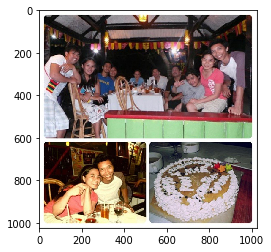

In [47]:
img_path = cv2.imread("/mnt/disks/open-images/images/train/000002b66c9c498e.jpg")
img = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()